# <span style="color:red"> Modelling - Score Analysis </span>

## comparing the scores of the models tested
* read in pickle of the main dataframe
* read in pickle models from earlier testing
* compare scores

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textacy
import re
import pickle
import os

from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import label_binarize

import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", 3))

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

plt.style.use('ggplot')

# import class to run modelling steps
from translator_modelling import Modelling

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# extend limit of number of rows and columns to display in cell
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100


Bad key "text.kerning_factor" on line 4 in
/Users/Steven/opt/anaconda3/envs/textacy/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### Load the dataframe containing text chunks and related variables

In [2]:
in_full_path = '../../../../Documents/murakami/pkl3/df_all_v02.pkl'
# read back pickle
with open (in_full_path, 'rb') as fp:
    df = pickle.load(fp)

### Check the dataframe is as expected

In [3]:
df.head(1)

,book_chunk_no,number,title,text,fstop_indices,split_indices,chunks,translator,book_title,parsed,n_sents,n_words,n_chars,n_syllables,n_unique_words,n_long_words,n_monosyllable_words,n_polysyllable_words,trans_code,chunk_length,n_sents_norm,n_words_norm,n_chars_norm,n_syllables_norm,n_unique_words_norm,n_long_words_norm,n_monosyllable_words_norm,n_polysyllable_words_norm,vader_compound,vader_neg,vader_neu,vader_pos,pron_count,verb_count,det_count,adj_count,num_count,punct_count,noun_count,adp_count,cconj_count,sconj_count,adv_count,aux_count,part_count,propn_count,space_count,intj_count,sym_count,x_count,...,then_adv,more_adv,even_adv,why_adv,maybe_adv,again_adv,now_adv,just_adv,how_adv,where_adv,very_adv,only_adv,there_adv,still_adv,so_adv,too_adv,when_adv,all_adv,here_adv,never_adv,as_adv,new_adj,other_adj,more_adj,small_adj,deep_adj,whole_adj,first_adj,bad_adj,little_adj,next_adj,much_adj,own_adj,hard_adj,last_adj,only_adj,big_adj,right_adj,long_adj,old_adj,strange_adj,same_adj,young_adj,sure_adj,able_adj,real_adj,different_adj,good_adj,few_adj,vlong_words_count
0,0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",IT WAS A short one-paragraph item in the morni...,Alfred Birnbaum,A Wild Sheep Chase,"(IT, WAS, A, short, one, -, paragraph, item, i...",15,174,742,240,116,33,128,17,0,944,15.889831,184.322034,786.016949,254.237288,122.881356,34.957627,135.59322,18.008475,-0.4798,0.075,0.862,0.064,18.0,20.0,31.0,9.0,2.0,33.0,51.0,19.0,6.0,3.0,5.0,5.0,3.0,2.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [4]:
df.shape

(5212, 142)

### Check the baseline

In [5]:
baseline_acc = df['trans_code'].value_counts(normalize=True).max()
baseline_acc

0.39927091327705294

### Make train test split

In [6]:
model = LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=1000)
lr = Modelling(df, model)

predictor_cols = lr.feature_select(basic_counts=True, pos_counts=True, vader=False, words=True, 
                                   adj=True, adv=True)
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm']
predictor_cols = lr.drop_features(predictor_cols, cols_to_drop)

X_train, X_test, y_train, y_test, idx_train, idx_test = lr.modelling_prep(predictor_cols, 'trans_code')

### Load Models

In [7]:
pkl_list = os.listdir('../../../../Documents/murakami/pkl_models/')
pkl_list_sel = [x for x in pkl_list if '_gs_' in x]
pkl_list_sel

['dt_gs_01.pkl',
 'svm_gs_01.pkl',
 'gb_gs_01.pkl',
 'bg_knn_gs_01.pkl',
 'xgb_gs_01.pkl',
 'svm_l_gs_01.pkl',
 'lreg_gs_04.pkl',
 'lreg_gs_05.pkl',
 'lreg_gs_06.pkl',
 'lreg_gs_02.pkl',
 'lreg_gs_03.pkl',
 'lreg_gs_final.pkl',
 'lreg_gs_01.pkl',
 'bs_dt_gs_01.pkl',
 'rfc_gs_01.pkl',
 'bg_dt_gs_01.pkl',
 'knn_gs_01.pkl',
 'mlp_gs_01.pkl']

In [8]:
def load_pickle(filename):
    in_path = '../../../../Documents/murakami/pkl_models/' + filename
    with open (in_path, 'rb') as fp:
        return pickle.load(fp)

In [9]:
model_no_dict = {'lreg_gs_final': 1,
                 'knn_gs_01': 2,
                 'dt_gs_01': 3,
                 'rfc_gs_01': 4,
                 'bg_dt_gs_01': 5,
                 'bg_knn_gs_01': 6,
                 'bs_dt_gs_01': 7,
                 'gb_gs_01': 8,
                 'xgb_gs_01': 9,
                 'svm_l_gs_01': 10,
                 'svm_gs_01': 11,
                 'mlp_gs_01': 12}

In [10]:
model_no_dict.keys()

dict_keys(['lreg_gs_final', 'knn_gs_01', 'dt_gs_01', 'rfc_gs_01', 'bg_dt_gs_01', 'bg_knn_gs_01', 'bs_dt_gs_01', 'gb_gs_01', 'xgb_gs_01', 'svm_l_gs_01', 'svm_gs_01', 'mlp_gs_01'])

In [11]:
model_dict = {}
for i, pk in enumerate(pkl_list_sel):
    model_name = pk.split('.')[0]
    if model_name in model_no_dict.keys():
        model_dict[model_name] = (model_no_dict[model_name], load_pickle(pk))

In [12]:
# model_dict

### Retrieve model scores

In [13]:
# {k: v for k, v in sorted(x.items(), key=lambda item: item[1])}
for model in model_dict:
    print(model_dict[model][0], model_dict[model][1].best_score_)

3 0.5389776054306614
11 0.6896096568123653
8 0.6872109995077167
6 0.5725550651915443
9 0.6908115764291328
10 0.6749810715653168
1 0.6766617438342244
7 0.6476377601400272
4 0.6533940194782948
5 0.660587400427797
2 0.5646428355514869
12 0.6884106160449791


In [14]:
df_mod_scores = pd.DataFrame.from_dict(model_dict, orient='index')

In [15]:
df_mod_scores.columns = ['model_no', 'model']

In [16]:
df_mod_scores

,model_no,model
dt_gs_01,3,"GridSearchCV(cv=5, error_score=nan,\n ..."
svm_gs_01,11,"GridSearchCV(cv=5, error_score=nan,\n ..."
gb_gs_01,8,"GridSearchCV(cv=5, error_score=nan,\n ..."
bg_knn_gs_01,6,"GridSearchCV(cv=5, error_score=nan,\n ..."
xgb_gs_01,9,"GridSearchCV(cv=5, error_score=nan,\n ..."
svm_l_gs_01,10,"GridSearchCV(cv=5, error_score=nan,\n ..."
lreg_gs_final,1,"GridSearchCV(cv=5, error_score=nan,\n ..."
bs_dt_gs_01,7,"GridSearchCV(cv=5, error_score=nan,\n ..."
rfc_gs_01,4,"GridSearchCV(cv=5, error_score=nan,\n ..."
bg_dt_gs_01,5,"GridSearchCV(cv=5, error_score=nan,\n ..."


In [17]:
df_mod_scores.iloc[7,:]

model_no                                                    7
model       GridSearchCV(cv=5, error_score=nan,\n         ...
Name: bs_dt_gs_01, dtype: object

In [18]:
df_mod_scores.iloc[10,1].score(X_test, y_test)

0.5906040268456376

In [19]:
def get_scores(df, X_train, y_train, X_test, y_test):
    df['cv_score'] = df['model'].apply(lambda x: x.best_score_)
    df['train_score'] = df['model'].apply(lambda x: x.score(X_train, y_train))
    df['test_score'] = df['model'].apply(lambda x: x.score(X_test, y_test))
    return df
df_mod_scores = get_scores(df_mod_scores, X_train, y_train, X_test, y_test)

In [20]:
df_mod_scores = df_mod_scores.sort_values('model_no')
df_mod_scores

,model_no,model,cv_score,train_score,test_score
lreg_gs_final,1,"GridSearchCV(cv=5, error_score=nan,\n ...",0.676662,0.700408,0.695110
knn_gs_01,2,"GridSearchCV(cv=5, error_score=nan,\n ...",0.564643,1.000000,0.590604
dt_gs_01,3,"GridSearchCV(cv=5, error_score=nan,\n ...",0.538978,0.592468,0.514861
rfc_gs_01,4,"GridSearchCV(cv=5, error_score=nan,\n ...",0.653394,0.981530,0.668265
bg_dt_gs_01,5,"GridSearchCV(cv=5, error_score=nan,\n ...",0.660587,1.000000,0.678811
bg_knn_gs_01,6,"GridSearchCV(cv=5, error_score=nan,\n ...",0.572555,0.797793,0.611697
bs_dt_gs_01,7,"GridSearchCV(cv=5, error_score=nan,\n ...",0.647638,0.733509,0.663471
gb_gs_01,8,"GridSearchCV(cv=5, error_score=nan,\n ...",0.687211,0.999041,0.697987
xgb_gs_01,9,"GridSearchCV(cv=5, error_score=nan,\n ...",0.690812,0.983689,0.708533
svm_l_gs_01,10,"GridSearchCV(cv=5, error_score=nan,\n ...",0.674981,0.700408,0.690316


In [28]:
df_mod_scores.drop('model_names', axis=1, inplace=True)

In [29]:
model_names_dict = {'model_names': ['logistic regression', 'knn', 'decision tree', 'random forest', 
                                    'baging decision tree', 'bagging knn', 'boosting decision tree', 
                                    'gradient boost', 'xg boost', 'svm linear', 'svm rbf', 
                                     'mlp neural net']}
model_names = pd.DataFrame(model_names_dict)
df_mod_scores = df_mod_scores.reset_index().join(model_names)

In [30]:
model_names_dict

{'model_names': ['logistic regression',
  'knn',
  'decision tree',
  'random forest',
  'baging decision tree',
  'bagging knn',
  'boosting decision tree',
  'gradient boost',
  'xg boost',
  'svm linear',
  'svm rbf',
  'mlp neural net']}

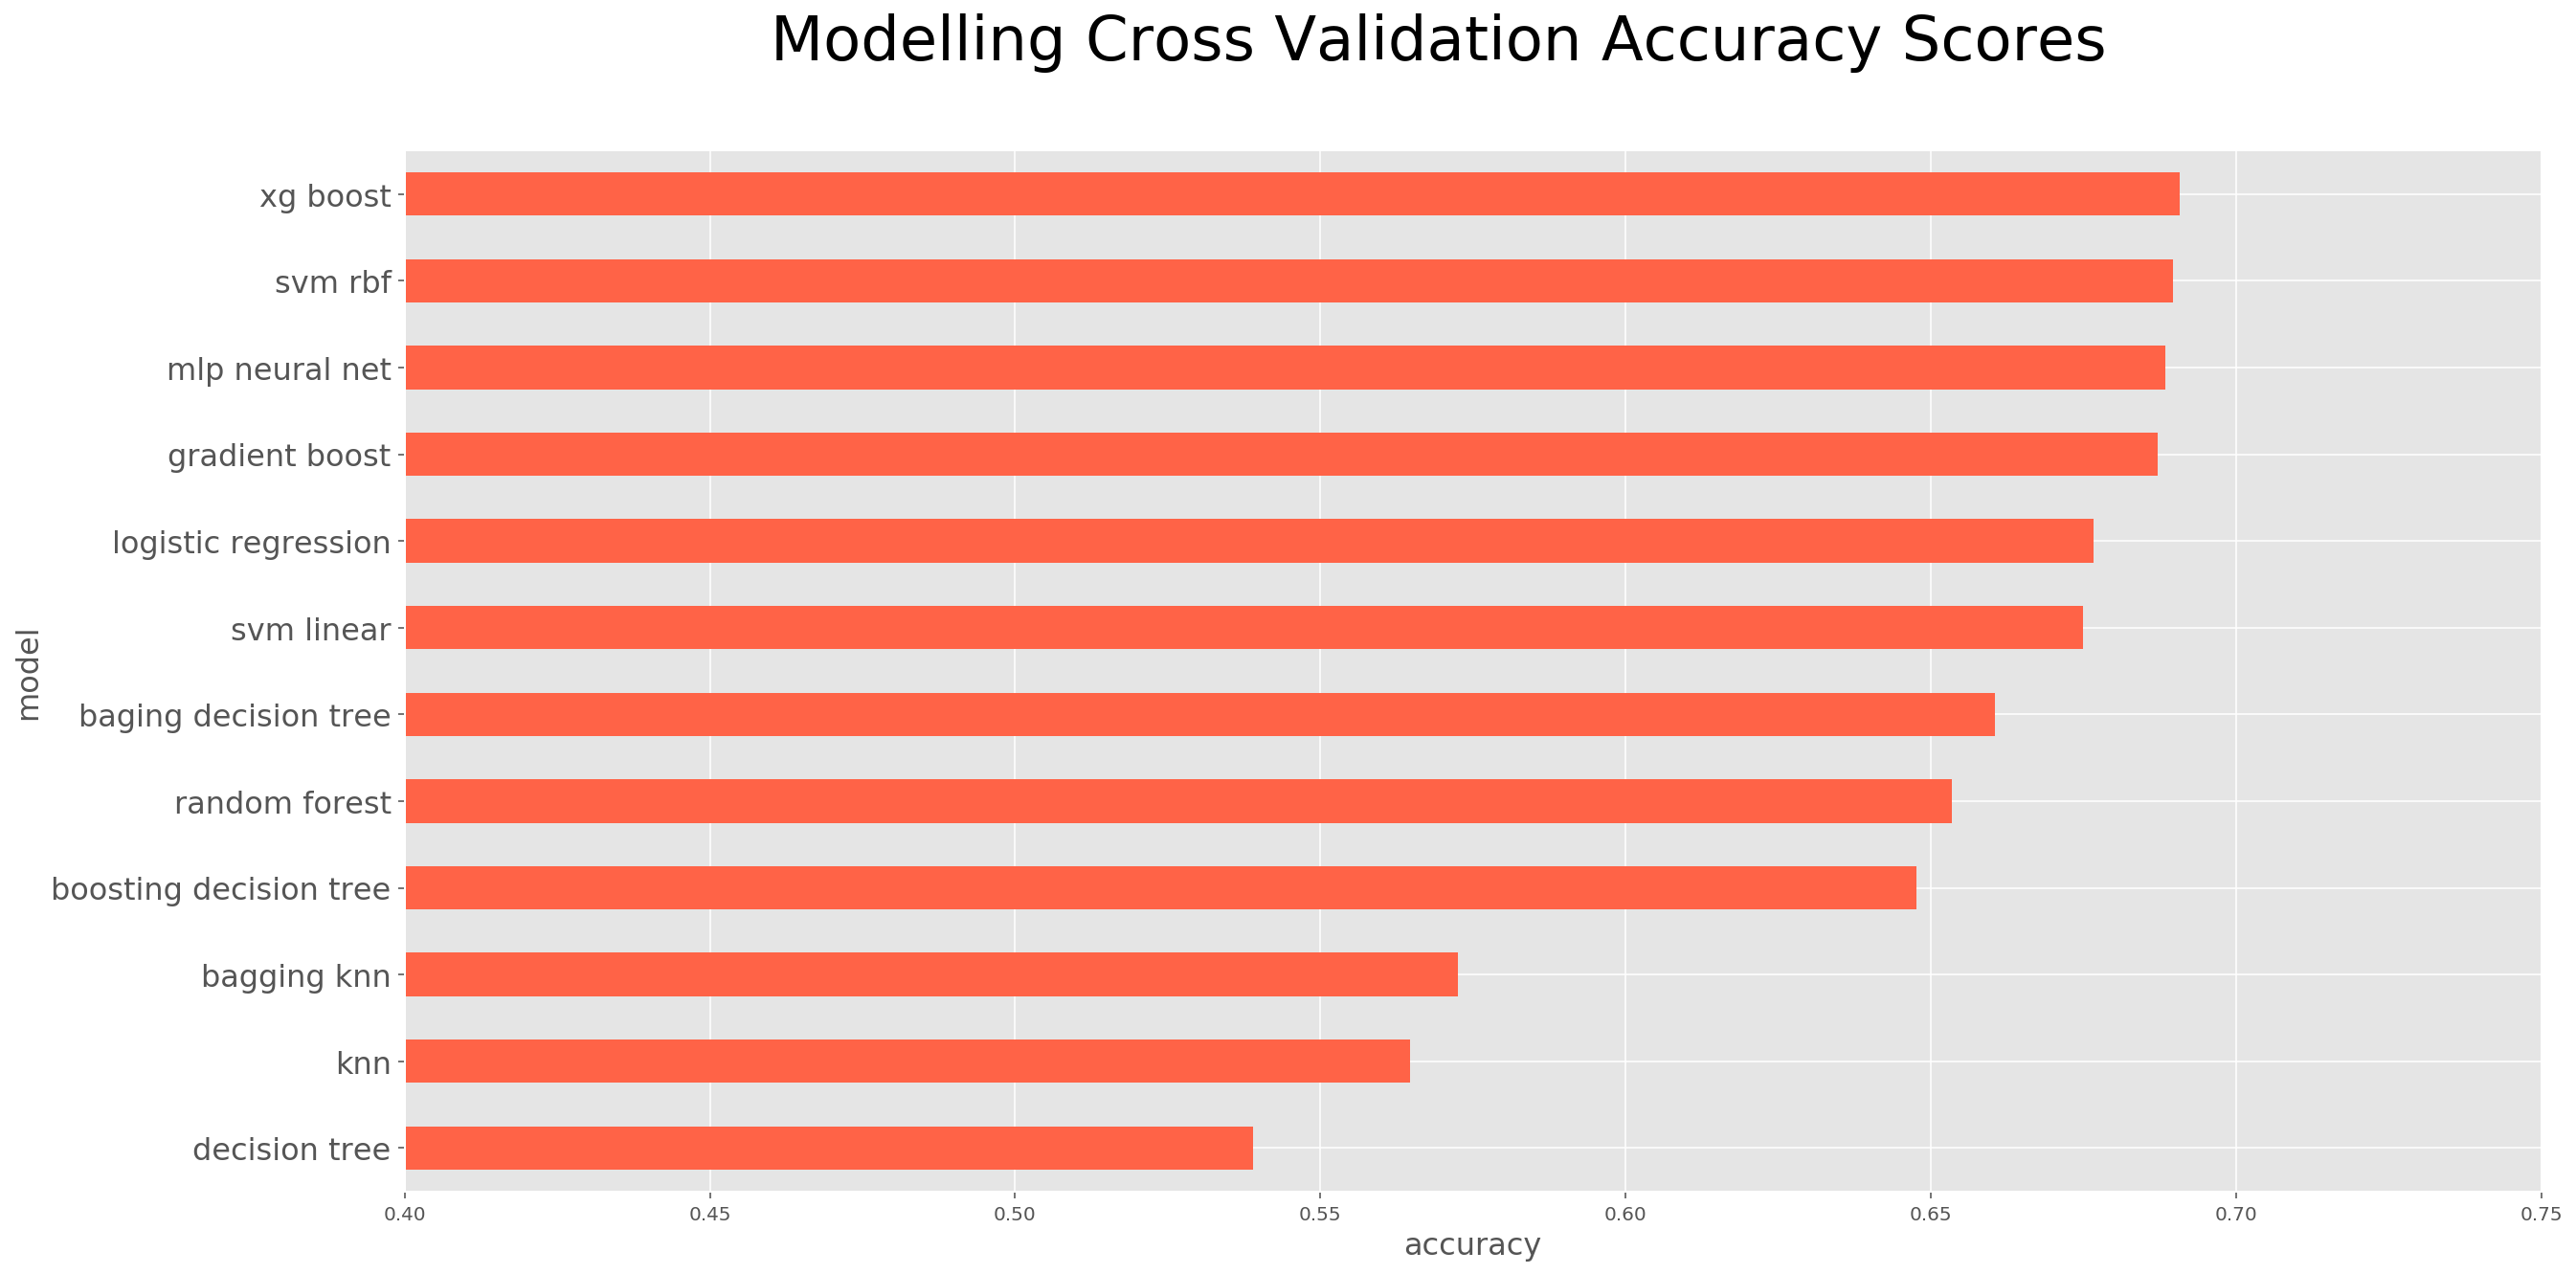

In [39]:
sns.set_palette(['tomato'])
fig, ax = plt.subplots(figsize=(20, 10))
fig.suptitle('Modelling Cross Validation Accuracy Scores', fontsize=32)
df_mod_scores.set_index('model_names').sort_values('cv_score').plot.barh(y='cv_score', ax=ax)
ax.set_xlim(0.40,0.75)
ax.set_xlabel('accuracy', fontsize=16)
ax.set_ylabel('model', fontsize=16)
ax.tick_params(axis="y", labelsize=16)
ax.get_legend().remove()
plt.savefig('../../../../Documents/murakami/plots/model_cv_acc_comparison_01.png', bbox_inches = 'tight')
plt.show()

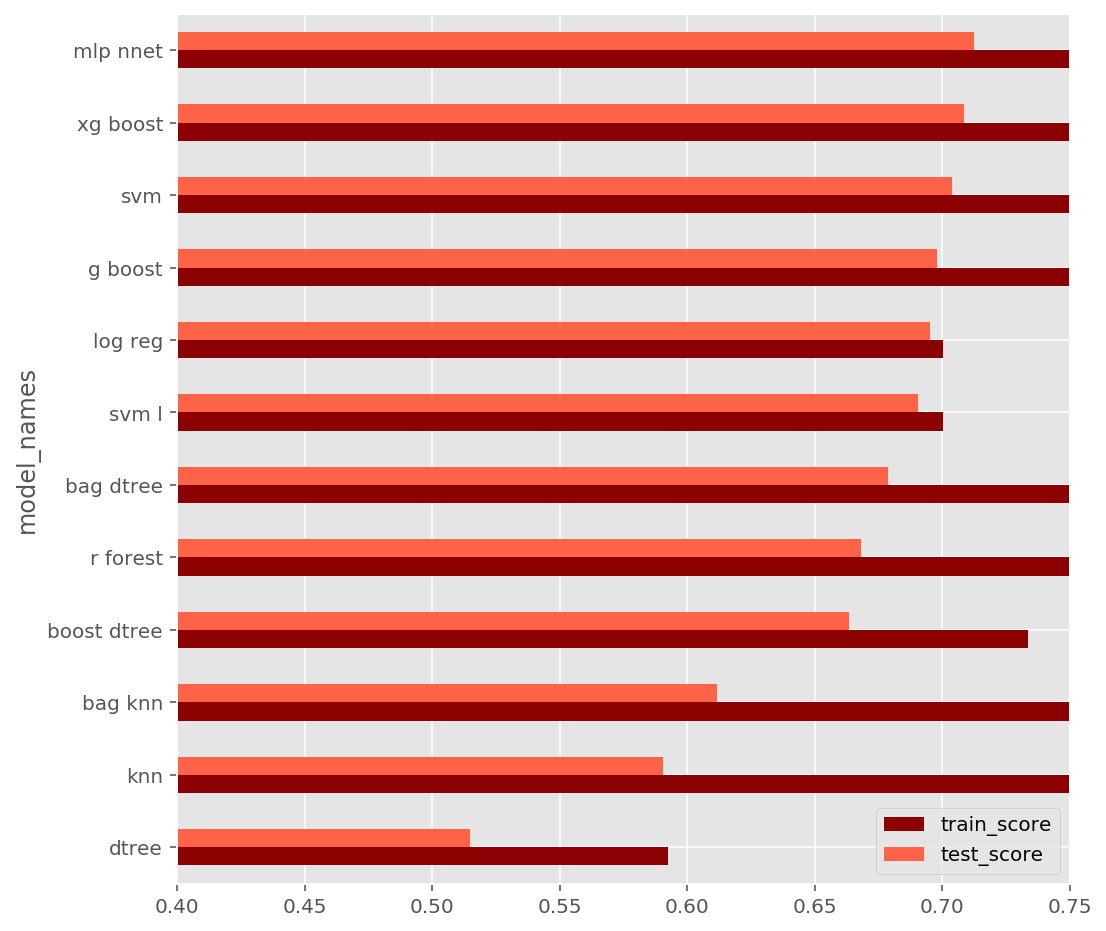

In [25]:
sns.set_palette(['darkred', 'tomato', 'gray'])
fig, ax = plt.subplots(figsize=(8, 8))
df_mod_scores.set_index('model_names')[['train_score', 'test_score']].sort_values('test_score').plot.barh(ax=ax)
ax.set_xlim(0.40,0.75)
plt.savefig('../../../../Documents/murakami/plots/model_train_test_acc_comparison_01.png')
plt.show()